In [1]:
import pandas as pd 
import matplotlib.pyplot as plt  

In [2]:
df_credit = pd.read_csv("german_credit_data.csv")
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
#Looking unique values
print(df_credit.nunique())

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64


### Feature engineering 

In [4]:
#Creating an categorical variable to handle with the Age variable

#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)


df_good = df_credit[df_credit["Risk"] == 'good']
df_bad = df_credit[df_credit["Risk"] == 'bad']

In [5]:
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,67,male,2,own,NaN,little,1169,6,radio/TV,good,Senior
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,Student
2,49,male,1,own,little,NaN,2096,12,education,good,Adult
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,Adult
4,53,male,2,free,little,little,4870,24,car,bad,Adult


In [6]:
print("Purpose : ",df_credit.Purpose.unique())
print("Sex : ",df_credit.Sex.unique())
print("Housing : ",df_credit.Housing.unique())
print("Saving accounts : ",df_credit['Saving accounts'].unique())
print("Risk : ",df_credit['Risk'].unique())
print("Checking account : ",df_credit['Checking account'].unique())
print("Aget_cat : ",df_credit['Age_cat'].unique())

Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Sex :  ['male' 'female']
Housing :  ['own' 'free' 'rent']
Saving accounts :  [nan 'little' 'quite rich' 'rich' 'moderate']
Risk :  ['good' 'bad']
Checking account :  ['little' 'moderate' nan 'rich']
Aget_cat :  ['Senior', 'Student', 'Adult', 'Young']
Categories (4, object): ['Student' < 'Young' < 'Adult' < 'Senior']


In [7]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [8]:
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

#Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Sex feature in dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

In [9]:
del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
del df_credit["Sex"]
del df_credit["Housing"]
del df_credit["Age_cat"]
del df_credit["Risk"]
del df_credit['Risk_good']
del df_credit['Age']

In [10]:
df_credit.head()

,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,...,Savings_no_inf,Savings_quite rich,Savings_rich,Risk_bad,Check_moderate,Check_no_inf,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior
0,2,1169,6,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2,5951,48,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
2,1,2096,12,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,2,7882,42,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2,4870,24,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


### Train model 

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

df_credit['Credit amount'] = np.log(df_credit['Credit amount'])
X = df_credit.drop('Risk_bad', 1).values
y = df_credit["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [12]:
param_grid = {"max_depth": [3,5, 7, 10, None],
              "n_estimators":[25,50,100,150],
              "max_features": [5,10,15,20]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2),
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'max_features': [5, 10, 15, 20],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='recall')

In [13]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.49091787439613527
{'max_depth': None, 'max_features': 20, 'n_estimators': 25}


In [14]:
rf = RandomForestClassifier(max_depth=None, max_features=20, n_estimators=25, random_state=2)

#trainning with the best params
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=20, n_estimators=25, random_state=2)

### Model evaluation 

In [15]:
from sklearn.metrics import roc_auc_score
#Testing the model 
#Predicting using our  model
y_pred = rf.predict(X_test)

# Verificaar os resultados obtidos
print("accuracy: ", accuracy_score(y_test,y_pred))
print("Confusion matrix: ")
print(confusion_matrix(y_test, y_pred))
print("roc_auc: ", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

accuracy:  0.716
Confusion matrix: 
[[150  28]
 [ 43  29]]
roc_auc:  0.7249141697877654


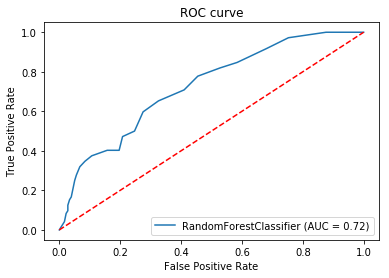

In [16]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rf, X_test, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC curve")
plt.show()

### Fairness -- anti-classification

In [17]:
#gender -- column 10 is gender 
print(len(df_credit.columns))
df_credit.columns

24


Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Savings_moderate', 'Savings_no_inf', 'Savings_quite rich',
       'Savings_rich', 'Risk_bad', 'Check_moderate', 'Check_no_inf',
       'Check_rich', 'Age_cat_Young', 'Age_cat_Adult', 'Age_cat_Senior'],
      dtype='object')

In [18]:
X_test_flip_gender = np.delete(X_test, 10, 1)
gender_col = 1 - X_test[:, 10]
X_test_flip_gender = np.insert(X_test_flip_gender, 10, gender_col, 1)
X_test_flip_gender.shape

(250, 23)

In [19]:
y_pred_flip_gender = rf.predict(X_test_flip_gender)

In [20]:
count = 0
for i in range (len(y_pred)):
    if y_pred[i] != y_pred_flip_gender[i]:
        count += 1 
        
print("The number of prediction change due to gender is: ", count)
print("The rate is: ", count/len(y_pred))

The number of prediction change due to gender is:  22
The rate is:  0.088


In [21]:
#age -- the last three columns are related to age 
age_cols = np.random.randint(2, size=3*len(y_pred)).reshape(-1, 3)
X_test_flip_age = np.concatenate((X_test[:, :-3], age_cols), axis=1)
X_test_flip_age.shape

(250, 23)

In [22]:
y_pred_flip_age = rf.predict(X_test_flip_age)

In [23]:
count = 0
for i in range (len(y_pred)):
    if y_pred[i] != y_pred_flip_age[i]:
        count += 1 
        
print("The number of prediction change due to age is: ", count)
print("The rate is: ", count/len(y_pred))

The number of prediction change due to age is:  18
The rate is:  0.072


### Fairness -- independence

In [60]:
# gender 
gender_col = X_test[:, 10]
male_count = 0
female_count = 0
male_risk_bad = 0
female_risk_bad = 0
for i in range (len(gender_col)):
    if gender_col[i] == 1:
        male_count += 1 
        if y_pred[i] == 1:
            male_risk_bad += 1 
    else:
        female_count += 1
        if y_pred[i] == 1:
            female_risk_bad += 1 
print("Number of female: ", female_count)
print("Number of male: ", male_count)
print("P(risk=bad|gender=female) = ", female_risk_bad/female_count)
print("P(risk=bad|gender=male) = ", male_risk_bad/male_count)

Number of female:  73
Number of male:  177
P(risk=bad|gender=female) =  0.3150684931506849
P(risk=bad|gender=male) =  0.192090395480226


In [61]:
# age 
age_cols = X_test[:, -3:]
young = 0 
young_risk_bad = 0 
student = 0 
student_risk_bad = 0 
senior = 0 
senior_risk_bad = 0
adult = 0
adult_risk_bad = 0 

for i in range (len(y_pred)):
    if list(age_cols[i, :]) == [1.0, 0.0, 0.0]:
        young += 1 
        if y_pred[i] == 1: 
            young_risk_bad += 1  
    elif list(age_cols[i, :]) == [0.0, 1.0, 0.0]:
        adult += 1 
        if y_pred[i] == 1: 
            adult_risk_bad += 1 
    elif list(age_cols[i, :]) == [0.0, 0.0, 1.0]:
        senior += 1 
        if y_pred[i] == 1: 
            senior_risk_bad +=1 
    else:
        student += 1
        if y_pred[i] == 1: 
            student_risk_bad += 1 

print("Number of youngs: ", young)
print("Number of students: ", student)
print("Number of adults: ", adult)
print("Number of seniors: ", senior )
print("P(risk=bad|age = young) = ", young_risk_bad/young)
print("P(risk=bad|age = student) = ", student_risk_bad/student)
print("P(risk=bad|age = adult) = ", adult_risk_bad/adult)
print("P(risk=bad|age = senior) = ", senior_risk_bad/senior)

Number of youngs:  94
Number of students:  51
Number of adults:  92
Number of seniors:  13
P(risk=bad|age = young) =  0.1702127659574468
P(risk=bad|age = student) =  0.45098039215686275
P(risk=bad|age = adult) =  0.14130434782608695
P(risk=bad|age = senior) =  0.38461538461538464


### Fairness -- separation

In [62]:
# gender -- false negative rate 
false_neg_female = 0 
false_neg_male = 0 
risk_female = 0 
risk_male = 0
for i in range (len(gender_col)):
    if gender_col[i] == 1 and y_test[i] == 1:
        risk_male += 1 
        if y_pred[i] == 0:
            false_neg_male += 1 
    elif gender_col[i] == 0 and y_test[i] == 1:
        risk_female += 1
        if y_pred[i] == 0:
            false_neg_female += 1 
print("Number of risk female: ", risk_female)
print("Number of risk male: ", risk_male)
print("P(predicted_risk=good|gender=female, actual_risk=bad) = ", false_neg_female/risk_female)
print("P(predicted_risk=good|gender=male, actual_risk=bad) = ", false_neg_male/risk_male)

Number of risk female:  22
Number of risk male:  50
P(predicted_risk=good|gender=female, actual_risk=bad) =  0.5909090909090909
P(predicted_risk=good|gender=male, actual_risk=bad) =  0.6


In [58]:
# age -- false negative rate 
false_neg_young = 0 
false_neg_student = 0 
false_neg_adult = 0 
false_neg_senior = 0 
risk_young = 0 
risk_student = 0
risk_adult = 0
risk_senior = 0 

for i in range (len(y_pred)):
    if list(age_cols[i, :]) == [1.0, 0.0, 0.0] and y_test[i] == 1:
        risk_young += 1 
        if y_pred[i] == 0: 
            false_neg_young += 1  
    elif list(age_cols[i, :]) == [0.0, 1.0, 0.0] and y_test[i] == 1:
        risk_adult += 1 
        if y_pred[i] == 0: 
            false_neg_adult += 1 
    elif list(age_cols[i, :]) == [0.0, 0.0, 1.0] and y_test[i] == 1:
        risk_senior += 1 
        if y_pred[i] == 0: 
            false_neg_senior +=1 
    elif list(age_cols[i, :]) == [0.0, 0.0, 0.0] and y_test[i] == 1:
        risk_student += 1
        if y_pred[i] == 0: 
            false_neg_student += 1 

print("Number of risk youngs: ", risk_young)
print("Number of risk students: ", risk_student)
print("Number of risk adults: ", risk_adult)
print("Number of risk seniors: ", risk_senior)
print("P(predicted_risk=good|age=young, actual_risk=bad) = ", false_neg_young/risk_young)
print("P(predicted_risk=good|age=student, actual_risk=bad) = ", false_neg_student/risk_student)
print("P(predicted_risk=good|age=adult, actual_risk=bad) = ", false_neg_adult/risk_adult)
print("P(predicted_risk=good|age=senior, actual_risk=bad) = ", false_neg_senior/risk_senior)

Number of risk youngs:  25
Number of risk students:  17
Number of risk adults:  25
Number of risk seniors:  5
P(predicted_risk=good|age=young, actual_risk=bad) =  0.72
P(predicted_risk=good|age=student, actual_risk=bad) =  0.35294117647058826
P(predicted_risk=good|age=adult, actual_risk=bad) =  0.68
P(predicted_risk=good|age=senior, actual_risk=bad) =  0.4


### Improve model fairness -- anti-classification 

In [50]:
X_train_anti = np.delete(X_train, 10, 1)

param_grid = {"max_depth": [3,5, 7, 10, None],
              "n_estimators":[25,50,100,150],
              "max_features": [5,10,15,20]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_anti, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2),
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'max_features': [5, 10, 15, 20],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='recall')

In [51]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.4865700483091787
{'max_depth': None, 'max_features': 20, 'n_estimators': 25}


In [52]:
# improve anti-classification 
rf_anti = RandomForestClassifier(max_depth=None, max_features=20, n_estimators=25, random_state=2)

#trainning with the best params
rf_anti.fit(X_train_anti, y_train)

RandomForestClassifier(max_features=20, n_estimators=25, random_state=2)

In [53]:
from sklearn.metrics import roc_auc_score
#Testing the model 
#Predicting using our  model
X_test_anti = np.delete(X_test, 10, 1)
y_pred_anti = rf_anti.predict(X_test_anti)

# Verificaar os resultados obtidos
print("accuracy: ", accuracy_score(y_test,y_pred_anti))
print("Confusion matrix: ")
print(confusion_matrix(y_test, y_pred_anti))
print("roc_auc: ", roc_auc_score(y_test, rf_anti.predict_proba(X_test_anti)[:, 1]))

accuracy:  0.736
Confusion matrix: 
[[153  25]
 [ 41  31]]
roc_auc:  0.6853152309612984


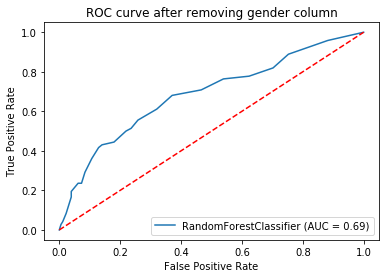

In [54]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rf_anti, X_test_anti, y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC curve after removing gender column")
plt.show()

### Improve model fairness -- independence

In [67]:
X_test_female = X_test[X_test[:, 10] == 0]
X_test_male = X_test[X_test[:, 10] == 1]

In [81]:
y_test_female = y_test[X_test[:, 10] == 0]
y_test_male = y_test[X_test[:, 10] == 1]

In [83]:
# The default threshold is 0.5 
# lower the threshold for female 
threshold = 0.6
predicted_proba = rf.predict_proba(X_test_female)
y_pred_female = (predicted_proba [:,1] >= threshold).astype('int')
print("P(risk = bad | gender = female) = ", len(y_pred_female[y_pred_female == 1])/len(y_pred_female))
print("Confusion matrix: ")
print(confusion_matrix(y_test_female, y_pred_female))

P(risk = bad | gender = female) =  0.1917808219178082
Confusion matrix: 
[[44  7]
 [15  7]]


In [84]:
# The default threshold is 0.5 
# Keep the default threshold for male 
threshold = 0.5
predicted_proba = rf.predict_proba(X_test_male)
y_pred_male = (predicted_proba [:,1] >= threshold).astype('int')
print("P(risk = bad | gender = male) = ", len(y_pred_male[y_pred_male == 1])/len(y_pred_male))
print("Confusion matrix: ")
print(confusion_matrix(y_test_male, y_pred_male))

P(risk = bad | gender = male) =  0.192090395480226
Confusion matrix: 
[[113  14]
 [ 30  20]]


In [86]:
print(accuracy_score(np.concatenate([y_test_male,y_test_female]), np.concatenate([y_pred_male,y_pred_female])))

0.736


### Improve model separation

In [138]:
threshold = 0.53
predicted_proba = rf.predict_proba(X_test_female)
y_pred_female = (predicted_proba [:,1] >= threshold).astype('int')
print("Confusion matrix: ")
print(confusion_matrix(y_test_female, y_pred_female))

Confusion matrix: 
[[41 10]
 [14  8]]


In [139]:
# gender -- false negative rate 
false_neg_female = 0 
risk_female = 0 
for i in range (len(y_pred_female)):
    if y_test_female[i] == 1:
        risk_female += 1 
        if y_pred_female[i] == 0:
            false_neg_female += 1 
print("Number of risk female: ", risk_female)
print("P(predicted_risk=good|gender=female, actual_risk=bad) = ", false_neg_female/risk_female)

Number of risk female:  22
P(predicted_risk=good|gender=female, actual_risk=bad) =  0.6363636363636364
